In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

# Reprodutibilidade
SEED = 42
np.random.seed(SEED)


In [3]:
import kagglehub

print("⏳ Baixando HAM10000 via kagglehub...")
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("📁 Path:", path)


/home/davi/projects/skinDeseases/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


⏳ Baixando HAM10000 via kagglehub...


100%|██████████| 5.20G/5.20G [09:04<00:00, 10.2MB/s]  

Extracting files...


📁 Path: /home/davi/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2


In [4]:
# Os arquivos vêm organizados dentro do diretório baixado:
# - HAM10000_metadata.csv
# - HAM10000_images_part_1/
# - HAM10000_images_part_2/

metadata_path = os.path.join(path, "HAM10000_metadata.csv")
img_dir_1 = os.path.join(path, "HAM10000_images_part_1")
img_dir_2 = os.path.join(path, "HAM10000_images_part_2")

print(metadata_path)
print(img_dir_1)
print(img_dir_2)


/home/davi/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_metadata.csv
/home/davi/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_images_part_1
/home/davi/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_images_part_2


In [5]:
df = pd.read_csv(metadata_path)
df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


# Remapear classes para (Benigno / Suspeito / Maligno)

In [6]:
def map_label(dx):
    if dx in ['mel', 'bcc', 'akiec']:
        return 'Maligno'
    elif dx == 'bkl':
        return 'Suspeito'
    elif dx in ['nv', 'df', 'vasc']:
        return 'Benigno'
    return None

df['label_3class'] = df['dx'].apply(map_label)
df = df.dropna(subset=['label_3class'])

df['label_3class'].value_counts()


label_3class
Benigno     6962
Maligno     1954
Suspeito    1099
Name: count, dtype: int64

# Criar split estratificado Treino/Teste

In [7]:
train_df, test_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df['label_3class'],
    random_state=SEED
)

print("Train size:", train_df.shape[0])
print("Test size:", test_df.shape[0])
print("\nDistribuição treino:\n", train_df['label_3class'].value_counts(normalize=True))
print("\nDistribuição teste:\n", test_df['label_3class'].value_counts(normalize=True))


Train size: 7010
Test size: 3005

Distribuição treino:
 label_3class
Benigno     0.69515
Maligno     0.19515
Suspeito    0.10970
Name: proportion, dtype: float64

Distribuição teste:
 label_3class
Benigno     0.695175
Maligno     0.195008
Suspeito    0.109817
Name: proportion, dtype: float64


## Função de leitura de imagens + teste

In [8]:
def load_image(image_id):
    # tenta nas duas pastas
    path1 = os.path.join(img_dir_1, f"{image_id}.jpg")
    path2 = os.path.join(img_dir_2, f"{image_id}.jpg")
    
    if os.path.exists(path1):
        return Image.open(path1)
    if os.path.exists(path2):
        return Image.open(path2)
    return None


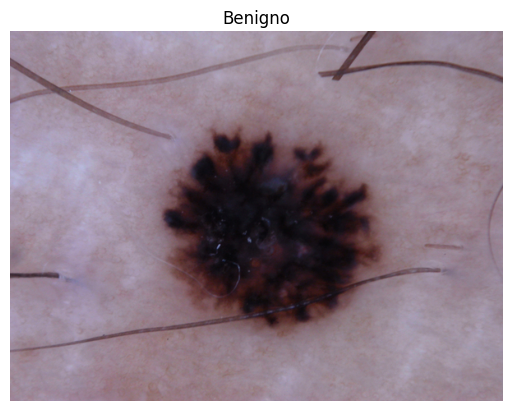

In [9]:
# Exibir imagem exemplo
sample = train_df.iloc[0]
img = load_image(sample["image_id"])

plt.imshow(img)
plt.title(sample["label_3class"])
plt.axis("off")
plt.show()


### Instalar dependências de features (scikit-image) e Importar funções de feature extraction


In [10]:
%pip install scikit-image

from skimage.feature import hog, local_binary_pattern
from skimage.color import rgb2gray
from skimage.transform import resize
import numpy as np
from matplotlib import colors



Note: you may need to restart the kernel to use updated packages.


## Função para extrair features de uma imagem
- Redimensionar para 128x128 (rápido e leve)
- Extrair:
    - HOG (orientação de bordas)
    - LBP (textura)
    - Histograma HSV (cor)
    - Concatenar tudo em um único vetor

In [11]:
def extract_features(img, size=(128,128)):
    # Redimensionar
    img = img.resize(size)
    img_np = np.array(img)

    # HOG (usa versão em grayscale)
    gray = rgb2gray(img_np)
    hog_features = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=False
    )

    # LBP (textura)
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(59), density=True)

    # Histograma de cor (HSV)
    hsv = colors.rgb_to_hsv(img_np / 255.0)
    h_hist, _ = np.histogram(hsv[:,:,0], bins=16, range=(0,1), density=True)
    s_hist, _ = np.histogram(hsv[:,:,1], bins=16, range=(0,1), density=True)
    v_hist, _ = np.histogram(hsv[:,:,2], bins=16, range=(0,1), density=True)

    # Concatenar feature vector final
    features = np.concatenate([hog_features, lbp_hist, h_hist, s_hist, v_hist])

    return features


## Gerar features para todo o conjunto de treino/teste

In [12]:
def build_feature_matrix(df):
    X = []
    y = []

    for i, row in df.iterrows():
        img = load_image(row["image_id"])
        if img is None:
            continue
        feat = extract_features(img)
        X.append(feat)
        y.append(row["label_3class"])
    
    return np.array(X), np.array(y)

print("⏳ Extraindo features do treino...")
X_train, y_train = build_feature_matrix(train_df)

print("⏳ Extraindo features do teste...")
X_test, y_test = build_feature_matrix(test_df)

X_train.shape, X_test.shape


⏳ Extraindo features do treino...


/home/davi/projects/skinDeseases/.venv/lib/python3.12/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


⏳ Extraindo features do teste...


((7010, 8206), (3005, 8206))

# SVM

In [13]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

svm_clf = SVC(kernel='rbf', C=2, gamma='scale')
svm_clf.fit(X_train, y_train)

y_pred_svm = svm_clf.predict(X_test)

print("===== SVM RESULTS =====")
print(classification_report(y_test, y_pred_svm))


===== SVM RESULTS =====
              precision    recall  f1-score   support

     Benigno       0.83      0.95      0.89      2089
     Maligno       0.58      0.49      0.53       586
    Suspeito       0.65      0.21      0.31       330

    accuracy                           0.78      3005
   macro avg       0.68      0.55      0.58      3005
weighted avg       0.76      0.78      0.75      3005



# Random Forest

Usamos class_weight = 'balanced' para forçar o modelo a dar peso maior às classes menores.

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=SEED,
    class_weight='balanced'
)

rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

print("===== RANDOM FOREST RESULTS (balanced) =====")
print(classification_report(y_test, y_pred_rf))


===== RANDOM FOREST RESULTS (balanced) =====
              precision    recall  f1-score   support

     Benigno       0.70      1.00      0.82      2089
     Maligno       0.71      0.02      0.03       586
    Suspeito       0.90      0.03      0.05       330

    accuracy                           0.70      3005
   macro avg       0.77      0.35      0.30      3005
weighted avg       0.73      0.70      0.58      3005



# Rede Neural MLP

Maximo de iterações elevada devido ao peso do MLP.
Usamos `early_stopping = True` para ele parar quando não houver melhora.

Convertemos os labels para números, porque o MLP com early_stopping não lida bem com strings.

In [15]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)


In [16]:
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(
    hidden_layer_sizes=(256,128),
    max_iter=300,
    early_stopping=True,
    n_iter_no_change=10,
    random_state=SEED
)


mlp_clf.fit(X_train, y_train_enc)
y_pred_mlp = mlp_clf.predict(X_test)

print("===== MLP RESULTS =====")
print(classification_report(y_test, le.inverse_transform(y_pred_mlp)))



===== MLP RESULTS =====
              precision    recall  f1-score   support

     Benigno       0.86      0.87      0.87      2089
     Maligno       0.48      0.57      0.52       586
    Suspeito       0.50      0.29      0.37       330

    accuracy                           0.75      3005
   macro avg       0.61      0.58      0.58      3005
weighted avg       0.75      0.75      0.75      3005



## Treinando o Modelo CNN (ResNet50)

Agora iniciamos a etapa principal do projeto: o treinamento de uma rede neural convolucional usando **Transfer Learning** com a **ResNet50**.  
Essa fase marca a transição dos modelos clássicos (SVM, Random Forest e MLP) para um modelo moderno e muito mais eficiente para reconhecimento de padrões em imagens dermatológicas.

Nesta parte do notebook, faremos:

1. **Organização das imagens em pastas** (train/valid/test), separadas por classe.
2. **Data augmentation**, para aumentar a robustez do modelo.
3. **Balanceamento das classes** usando `class_weight`, já que o HAM10000 é desbalanceado.
4. **Construção da ResNet50 pré-treinada no ImageNet**, removendo a última camada.
5. **Treinamento da cabeça da rede** (camadas densas finais).
6. **Fine-tuning** das últimas camadas convolucionais para melhorar a precisão.
7. **Avaliação final** no conjunto de teste (classification report + matriz de confusão).

Essa etapa geralmente produz resultados muito superiores aos métodos clássicos, pois CNNs conseguem aprender padrões visuais complexos presentes em imagens dermatoscópicas.


### Criar pastas e copiar imagens

In [18]:
import os
import sys

# Função para verificar se está no Google Colab
def is_colab():
    """Verifica se o ambiente de execução é o Google Colab."""
    return 'google.colab' in sys.modules

# Define o diretório base (raiz do projeto)
if is_colab():
    # Caminho seguro e gravável no Google Colab
    # Recomenda-se criar uma pasta de dados aqui.
    BASE_DIR = '/content/HAM10000_processed'
    print(f"Ambiente: Google Colab. Usando caminho: {BASE_DIR}")
else:
    # Caminho relativo ao diretório atual para execução local
    # As pastas serão criadas onde o notebook está salvo.
    BASE_DIR = './HAM10000_processed'
    # Use um caminho absoluto se preferir: BASE_DIR = os.path.join(os.path.expanduser('~'), 'seus_dados')
    print(f"Ambiente: Local. Usando caminho: {BASE_DIR}")

Ambiente: Local. Usando caminho: ./HAM10000_processed


In [19]:
import os
import shutil
from tqdm import tqdm

train_dir = os.path.join(BASE_DIR, 'train')
valid_dir = os.path.join(BASE_DIR, 'valid')
test_dir = os.path.join(BASE_DIR, 'test')

for d in [train_dir, valid_dir, test_dir]:
    for cls in ["Benigno","Maligno","Suspeito"]:
        os.makedirs(os.path.join(d, cls), exist_ok=True)

# função para obter path da imagem no HAM10000 baixado
def get_source_path(image_id):
    p1 = os.path.join(img_dir_1, f"{image_id}.jpg")
    p2 = os.path.join(img_dir_2, f"{image_id}.jpg")
    if os.path.exists(p1): return p1
    if os.path.exists(p2): return p2
    return None

# split: aqui usamos 70/15/15 — se já fez train/test (70/30), vamos criar valid a partir do test_df
# criar valid/test a partir de test_df: split test_df em valid/test (50/50 -> 15/15 total)
valid_df, final_test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['label_3class'], random_state=SEED)
train_df_copy = train_df.copy()
valid_df_copy = valid_df.copy()
test_df_copy  = final_test_df.copy()

# copiar arquivos
def copy_images(df, dest_dir):
    for _, row in tqdm(df.iterrows(), total=len(df)):
        src = get_source_path(row["image_id"])
        if src is None: 
            continue
        dst = os.path.join(dest_dir, row["label_3class"], f"{row['image_id']}.jpg")
        if not os.path.exists(dst):
            shutil.copy(src, dst)

print("Copiando treino...")
copy_images(train_df_copy, train_dir)
print("Copiando valid...")
copy_images(valid_df_copy, valid_dir)
print("Copiando test...")
copy_images(test_df_copy, test_dir)


Copiando treino...


100%|██████████| 7010/7010 [00:06<00:00, 1038.79it/s]


Copiando valid...


100%|██████████| 1502/1502 [00:01<00:00, 1123.37it/s]


Copiando test...


100%|██████████| 1503/1503 [00:04<00:00, 343.87it/s]


### ImageDataGenerator e geradores

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

IMG_SIZE = (224,224)
BATCH = 32

train_aug = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_aug = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen = train_aug.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

valid_gen = val_test_aug.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

test_gen = val_test_aug.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

print("Classes:", train_gen.class_indices)


2025-11-30 22:23:13.886920: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-30 22:23:13.897190: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-30 22:23:14.309275: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-30 22:23:15.955185: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

Found 7010 images belonging to 3 classes.
Found 1502 images belonging to 3 classes.
Found 1503 images belonging to 3 classes.
Classes: {'Benigno': 0, 'Maligno': 1, 'Suspeito': 2}


Calcular class_weight

In [21]:
from sklearn.utils import class_weight
import numpy as np

# obter labels numéricos do generator (mapa invertido)
inv_map = {v:k for k,v in train_gen.class_indices.items()}
# construir vetor de y para cálculo
y_train_for_weight = []
for cls, idx in train_gen.class_indices.items():
    folder = os.path.join(train_dir, cls)
    n = len(os.listdir(folder))
    y_train_for_weight += [train_gen.class_indices[cls]] * n
y_train_for_weight = np.array(y_train_for_weight)

cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_for_weight), y=y_train_for_weight)
class_weights = {i: cw[i] for i in range(len(cw))}
print("Class weights:", class_weights)


Class weights: {0: np.float64(0.47951296258294), 1: np.float64(1.7080896686159843), 2: np.float64(3.0385782401387083)}


### Construir modelo ResNet50 (transfer learning) e cabeçalho

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks

base = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    pooling='avg'
)

# Congelar a base
base.trainable = False

inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base(inputs, training=False)

# HEAD SIMPLIFICADA (mais estável)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(len(train_gen.class_indices), activation='softmax')(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


E0000 00:00:1764552213.139921  197266 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1764552213.146306  197266 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Treinar cabeça (fase 1)

In [24]:
import os
from tensorflow.keras import callbacks 

# --- Definindo o Caminho Dinâmico do Modelo ---

# Cria o caminho completo para salvar o modelo dentro do BASE_DIR
MODEL_SAVE_PATH = os.path.join(BASE_DIR, "resnet_head.keras")
print(f"O modelo será salvo em: {MODEL_SAVE_PATH}")


O modelo será salvo em: ./HAM10000_processed/resnet_head.keras


In [25]:


EPOCHS_HEAD = 15  

cb = [
    # Usa a variável MODEL_SAVE_PATH que é dinâmica (portátil)
    callbacks.ModelCheckpoint(MODEL_SAVE_PATH, save_best_only=True, monitor="val_accuracy"),
    callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
]

history_head = model.fit(
    train_gen,
    epochs=EPOCHS_HEAD,
    validation_data=valid_gen,
    class_weight=class_weights,
    callbacks=cb
)

Epoch 1/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 123s 558ms/step - accuracy: 0.6936 - loss: 0.7822 - val_accuracy: 0.6565 - val_loss: 0.7608
Epoch 2/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 129s 585ms/step - accuracy: 0.7168 - loss: 0.7233 - val_accuracy: 0.7130 - val_loss: 0.6326
Epoch 3/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 127s 576ms/step - accuracy: 0.7367 - loss: 0.6859 - val_accuracy: 0.7284 - val_loss: 0.6123
Epoch 4/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 131s 597ms/step - accuracy: 0.7378 - loss: 0.6671 - val_accuracy: 0.7304 - val_loss: 0.6131
Epoch 5/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 132s 598ms/step - accuracy: 0.7455 - loss: 0.6438 - val_accuracy: 0.7257 - val_loss: 0.6258
Epoch 6/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 129s 584ms/step - accuracy: 0.7578 - loss: 0.6252 - val_accuracy: 0.7144 - val_loss: 0.6386
Epoch 7/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 132s 601ms/step - accuracy: 0.7693 - loss: 0.5928 - val_accuracy: 0.7337 - val_loss: 0.6010
Epoch 8/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 133s 603ms/step - accuracy: 0.7782 -

### fine-tune (descongelar últimos blocos) e treinar

In [27]:
from tensorflow.keras import optimizers, callbacks

# --- 1. Definindo o Caminho Dinâmico do Modelo Finetuned ---
import os 
MODEL_SAVE_PATH_FINE = os.path.join(BASE_DIR, "resnet_finetuned.h5")
print(f"O modelo de fine-tuning será salvo em: {MODEL_SAVE_PATH_FINE}")


# --- 2. Configuração e Treinamento ---

# descongelar últimos blocos (ex.: últimos 20 layers)
base.trainable = True

# ajustar quais layers treinar: descongelar a partir de um bloco
fine_tune_at = -30  # ajusta conforme necessidade
for layer in base.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

EPOCHS_FINE = 20
cb2 = [
    # USANDO O CAMINHO DINÂMICO
    callbacks.ModelCheckpoint(MODEL_SAVE_PATH_FINE, save_best_only=True, monitor="val_accuracy"),
    callbacks.EarlyStopping(monitor="val_accuracy", patience=7, restore_best_weights=True)
]

history_fine = model.fit(
    train_gen,
    epochs=EPOCHS_FINE,
    validation_data=valid_gen,
    class_weight=class_weights,
    callbacks=cb2
)

O modelo de fine-tuning será salvo em: ./HAM10000_processed/resnet_finetuned.h5
Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.7516 - loss: 0.7516

220/220 ━━━━━━━━━━━━━━━━━━━━ 157s 692ms/step - accuracy: 0.7455 - loss: 0.6888 - val_accuracy: 0.7710 - val_loss: 0.5616
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.7735 - loss: 0.5750

220/220 ━━━━━━━━━━━━━━━━━━━━ 159s 722ms/step - accuracy: 0.7817 - loss: 0.5548 - val_accuracy: 0.7723 - val_loss: 0.5596
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 157s 711ms/step - accuracy: 0.8058 - loss: 0.4965 - val_accuracy: 0.7563 - val_loss: 0.5977
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.8142 - loss: 0.4649

220/220 ━━━━━━━━━━━━━━━━━━━━ 157s 714ms/step - accuracy: 0.8237 - loss: 0.4523 - val_accuracy: 0.7889 - val_loss: 0.5181
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 162s 719ms/step - accuracy: 0.8381 - loss: 0.4137 - val_accuracy: 0.7856 - val_loss: 0.5468
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.8611 - loss: 0.3585

220/220 ━━━━━━━━━━━━━━━━━━━━ 158s 720ms/step - accuracy: 0.8595 - loss: 0.3614 - val_accuracy: 0.7903 - val_loss: 0.5072
Epoch 7/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 161s 731ms/step - accuracy: 0.8695 - loss: 0.3192 - val_accuracy: 0.7803 - val_loss: 0.5849
Epoch 8/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 157s 715ms/step - accuracy: 0.8806 - loss: 0.2924 - val_accuracy: 0.7750 - val_loss: 0.5748
Epoch 9/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 161s 730ms/step - accuracy: 0.8967 - loss: 0.2644 - val_accuracy: 0.7903 - val_loss: 0.5972
Epoch 10/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 158s 720ms/step - accuracy: 0.8976 - loss: 0.2394 - val_accuracy: 0.7903 - val_loss: 0.5779
Epoch 11/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.9052 - loss: 0.2233

220/220 ━━━━━━━━━━━━━━━━━━━━ 158s 716ms/step - accuracy: 0.9093 - loss: 0.2147 - val_accuracy: 0.8282 - val_loss: 0.4809
Epoch 12/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 162s 734ms/step - accuracy: 0.9148 - loss: 0.1973 - val_accuracy: 0.8116 - val_loss: 0.5327
Epoch 13/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 158s 715ms/step - accuracy: 0.9260 - loss: 0.1838 - val_accuracy: 0.8076 - val_loss: 0.5784
Epoch 14/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 158s 716ms/step - accuracy: 0.9310 - loss: 0.1640 - val_accuracy: 0.8049 - val_loss: 0.5602
Epoch 15/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 161s 730ms/step - accuracy: 0.9351 - loss: 0.1539 - val_accuracy: 0.8236 - val_loss: 0.5349
Epoch 16/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 157s 713ms/step - accuracy: 0.9415 - loss: 0.1340 - val_accuracy: 0.8216 - val_loss: 0.5624
Epoch 17/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 160s 726ms/step - accuracy: 0.9472 - loss: 0.1223 - val_accuracy: 0.8149 - val_loss: 0.5774
Epoch 18/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.9488 - loss:

220/220 ━━━━━━━━━━━━━━━━━━━━ 158s 715ms/step - accuracy: 0.9481 - loss: 0.1263 - val_accuracy: 0.8336 - val_loss: 0.5455
Epoch 19/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 160s 728ms/step - accuracy: 0.9539 - loss: 0.1148 - val_accuracy: 0.8256 - val_loss: 0.5707
Epoch 20/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 158s 718ms/step - accuracy: 0.9619 - loss: 0.0915 - val_accuracy: 0.8209 - val_loss: 0.5973


### avaliar no teste e gerar classification_report + matriz de confusão

Carregando modelo de: ./HAM10000_processed/resnet_finetuned.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 403ms/step
              precision    recall  f1-score   support

     Benigno       0.95      0.90      0.92      1045
     Maligno       0.75      0.72      0.74       293
    Suspeito       0.61      0.84      0.70       165

    accuracy                           0.86      1503
   macro avg       0.77      0.82      0.79      1503
weighted avg       0.87      0.86      0.86      1503



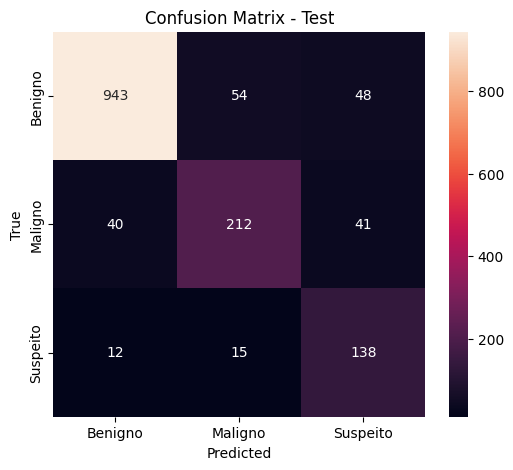

In [29]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tensorflow as tf

# --- 1. Definindo o Caminho Dinâmico do Modelo ---
MODEL_LOAD_PATH = os.path.join(BASE_DIR, "resnet_finetuned.h5")
print(f"Carregando modelo de: {MODEL_LOAD_PATH}")

# carregar melhor modelo salvo 
model = tf.keras.models.load_model(MODEL_LOAD_PATH)

# passos de teste
test_steps = int(np.ceil(test_gen.samples / BATCH))
y_true = test_gen.classes  # inteiros
y_prob = model.predict(test_gen, steps=test_steps, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

labels = list(train_gen.class_indices.keys())  # nome das classes na ordem do generator

print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test")
plt.show()

In [30]:
print(classification_report(y_true, y_pred, target_names=labels))


              precision    recall  f1-score   support

     Benigno       0.95      0.90      0.92      1045
     Maligno       0.75      0.72      0.74       293
    Suspeito       0.61      0.84      0.70       165

    accuracy                           0.86      1503
   macro avg       0.77      0.82      0.79      1503
weighted avg       0.87      0.86      0.86      1503

